# Sandbox for manually extracting spectra
### Olivia Cooper
### June 2022

In [1]:
# the basics

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import pandas as pd
import astropy
from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
import read_mospy_files as rmp ## script I made to read in mospy files
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
plt.style.use('../../cooper-presentation.mplstyle')

In [27]:
#notes = Table.read('../wmmc01/cooper_notes_wmmc01.csv',format='csv')
notes = Table.read('../wmmc05/cooper_notes_wmmc05.csv',format='csv')

notes

﻿slit_no,obj,ypix_mospy,mospy_notes,jake,pypeit_notes,confidence,zguess,zmeasured,wave,serendip_ra,serendip_dec,pypeit_ref_idx,pypeit_name,pypeit_slit,objra,objdec,spat_pixpos,spat_fracpos,box_width,opt_fwhm,s2n,maskdef_extract
int64,str26,int64,str37,str11,int64,int64,int64,int64,int64,float64,float64,int64,str23,int64,float64,float64,float64,float64,int64,float64,float64,str5
1,CAND_B58736,--,"nl,nc",10709,--,0,--,--,--,--,--,1500,SPAT1507-SLIT1500-DET01,1,150.13708,2.44008,1507.0,0.633,1,0.5,0.07,TRUE
2,M_WP549961,--,"nl,nc",--,--,0,--,--,--,--,--,1442,SPAT1444-SLIT1442-DET01,2,150.14004,2.43609,1444.0,0.551,1,0.5,0.07,TRUE
3,dl_cc_1069270.0,--,"nl,nc",--,--,0,--,--,--,--,--,1393,SPAT1393-SLIT1393-DET01,3,150.13921,2.43199,1393.0,0.5,1,0.5,0.05,TRUE
4,c2020_pz_4.25_26.9_614084,--,"nl,nc",10496,--,0,--,--,--,--,--,1344,SPAT1338-SLIT1344-DET01,4,150.145,2.42983,1338.0,0.367,1,0.5,0.0,TRUE
5,dl_cc_1062705.0,--,"nl,nc",--,--,0,--,--,--,--,--,1296,SPAT1295-SLIT1296-DET01,5,150.14175,2.42576,1295.0,0.464,1,0.5,0.03,TRUE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,SERENDIP,336,bc,--,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
29,c2020_pz_4.45_25.8_938343,309,l@9864?,--,--,1,--,--,9864,--,--,217,SPAT0218-SLIT0217-DET01,29,150.19375,2.3698,218.0,0.536,1,0.5,-2.88,TRUE
30,CAND_B43289,225,"l@9936?,l@11094?",--,--,1,--,--,9936,--,--,168,SPAT0160-SLIT0168-DET01,30,150.18946,2.36367,160.0,0.34,1,0.5,0.12,TRUE


In [32]:
idx = 33
obj_name = notes['obj'][idx]; zguess = float(notes['zmeasured'][idx]); lguess = float(notes['wave'][idx])
print('working on object',obj_name,'with zguess = ',zguess,'at lambda = ',lguess,'AA')
lguess

working on object c2020_pz_4.45_25.8_938343 with zguess =  nan at lambda =  9864.0 AA


/var/folders/pg/yy4jmlqx6jdd_b30vyvvg93h0000gq/T/ipykernel_44719/1038800376.py:2: UserWarning: Warning: converting a masked element to nan.
  obj_name = notes['obj'][idx]; zguess = float(notes['zmeasured'][idx]); lguess = float(notes['wave'][idx])


9864.0

In [248]:
# open 1D and 2D spectrum for an object

hdu2 = fits.open('../wmmc01/wmmc01_Y_'+obj_name+'_eps.fits') # 2D spectrum
hdu1 = fits.open('../wmmc01/wmmc01_Y_'+obj_name+'_1D_00.fits') # 1D spectrum
pix_obj, wav_obj, spec1d_obj = rmp.make_1d_array(ext=0,hdu=hdu1) # object spectrum
pix_sky, wav_sky, spec1d_sky = rmp.make_1d_array(ext=1,hdu=hdu1) # sky spectrum
image = hdu2[0].data
obj_pos = int(notes['spat_fracpos'][idx]*image.shape[0])-18
pixscale = hdu2[0].header['PSCALE'] # arcsec/pix
slitwidth = 2.5 # arcsec
nodamp = slitwidth/pixscale

In [360]:
obj_pos

22

candidate line at  9941.0 AA;  177.0 pix


Text(128.0, 0.15, 'z = 7.175')

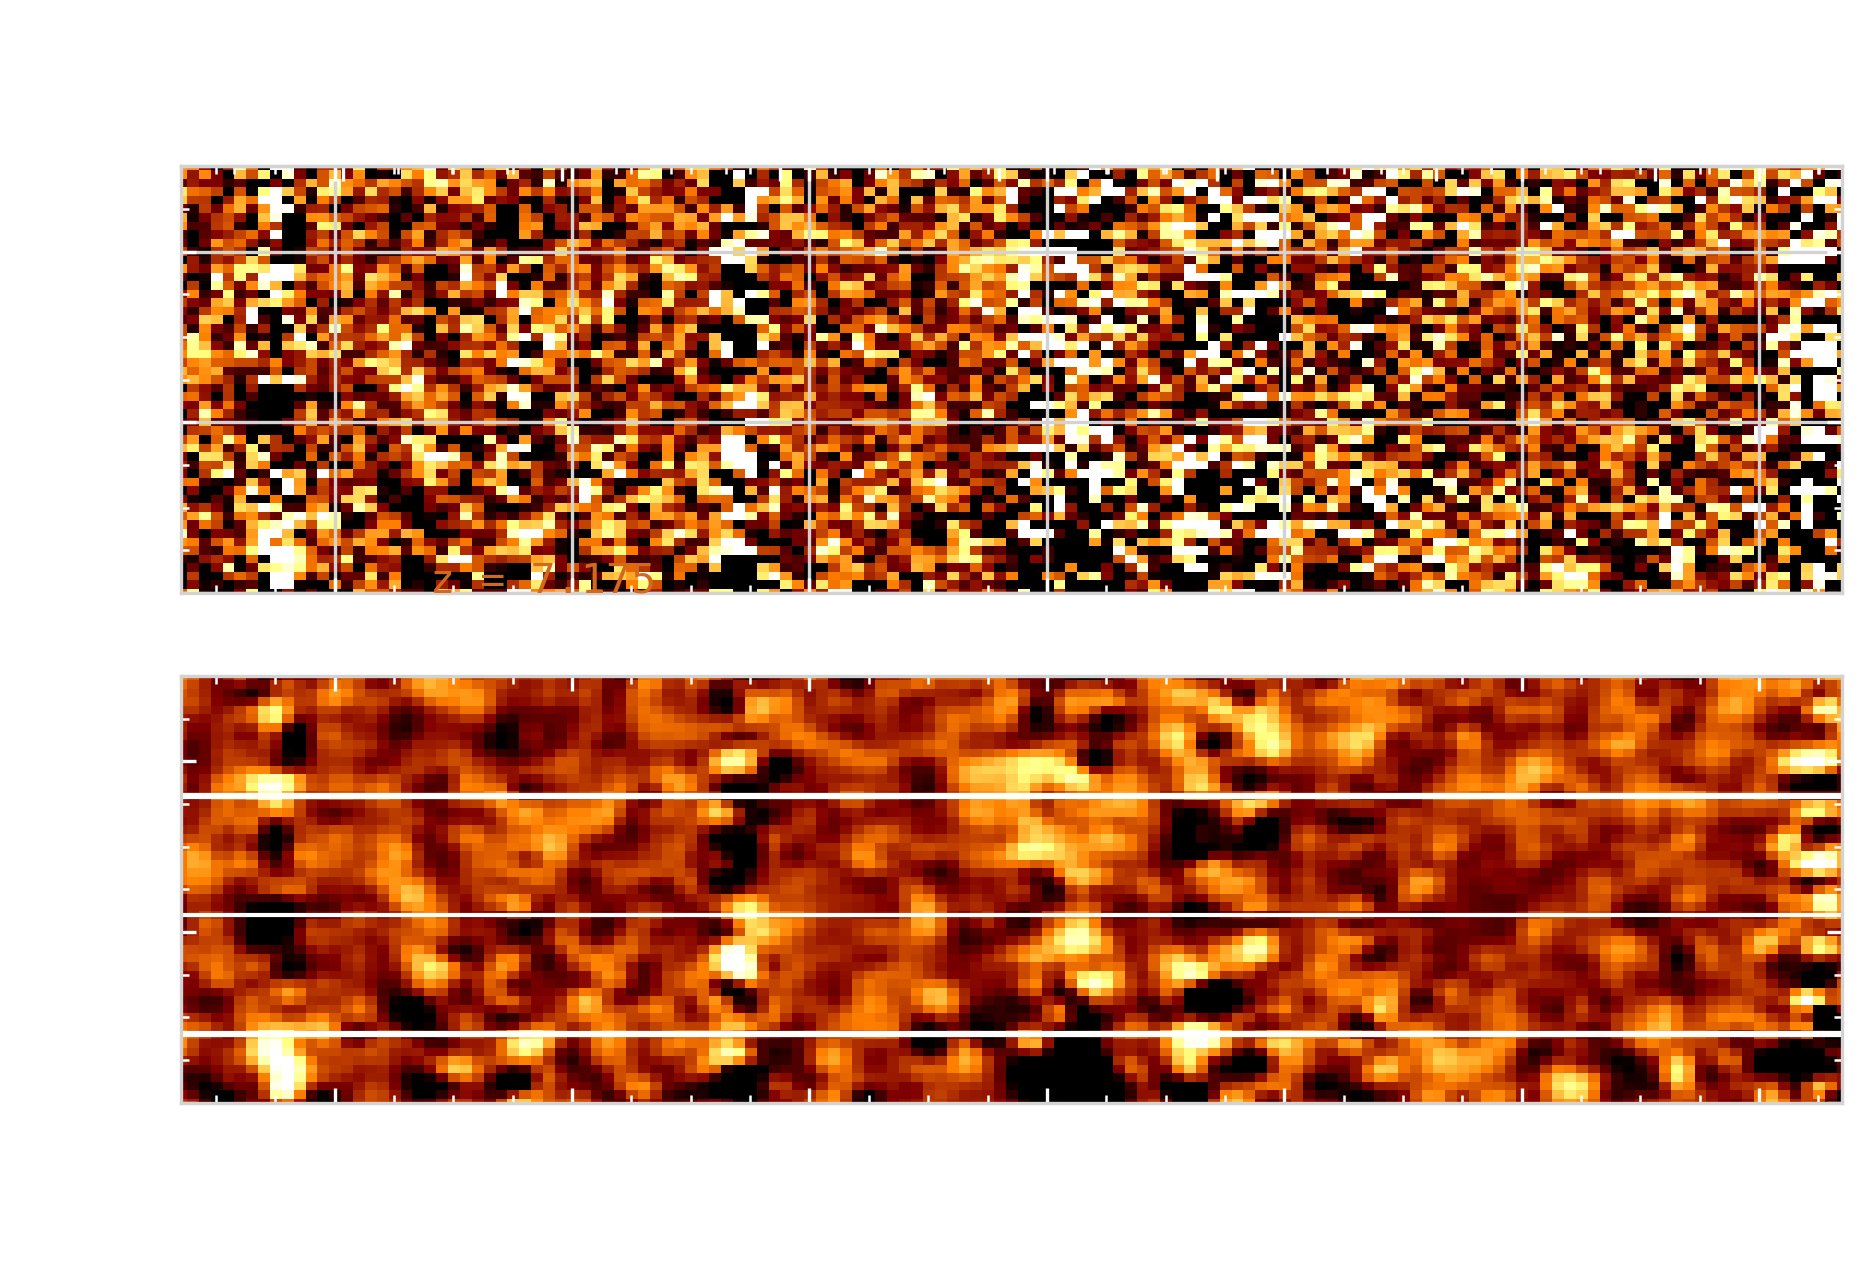

In [249]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

# ax1 = 1d spectrum in pixel space
#ax1.plot(pix_obj,spec1d_obj,c='chocolate',label=obj_name)
#ax1.fill_between(pix_sky, y1=spec1d_sky, y2=0, color='gray', label='sky')
ax1.set_ylabel(r'Flux')

xpix = 472; ypix = 19
### B_WP450980, ypix = 21
### B_WP567863, ypix = 34
#ypix1 = 18; ypix2 = 46
# ax2 = 2d spectrum in pixel space

### gaussian smooth
kernel = Gaussian2DKernel(x_stddev=1)
conv_im = convolve(hdu2[0].data, kernel)

lower=-1; upper=2
sample = sigma_clip(hdu2[0].data) 
vmin = sample.mean() + lower * sample.std()
vmax = sample.mean() + upper * sample.std()
ax1.imshow(hdu2[0].data, origin='lower', cmap='afmhot', aspect='auto', vmin=vmin, vmax=vmax)


ax2.imshow(conv_im, origin='lower', cmap='afmhot', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Column [Pix]')
ax2.set_ylabel('Row [Pix]')
ax2.grid(False)
#ax2.axhline(ypix,lw=1)

ax2.axhline(obj_pos,lw=1)
ax2.axhline(obj_pos+nodamp)
ax2.axhline(obj_pos-nodamp)
#ax2.axhline(ypix1,lw=1)
#ax2.axhline(ypix2,lw=1)
ax2.axvline(xpix,lw=1)

# secax = secondary axis for wavelength space

def forward(x):
    return np.interp(x, pix_obj, wav_obj)

def inverse(x):
    return np.interp(x, wav_obj, pix_obj)

secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r'Wavelength [$\AA$]')

# mark measured line at pixel guess based on lambda guess
pguess = pix_obj[rmp.closest(wav_obj,lguess)[0]] # pixel closest to wavelength of line to center on
print("candidate line at ",lguess,'AA; ',pguess,'pix')


### change limits!
ax1.set_xlim(pguess-70,pguess+70)
#ax1.set_ylim(-0.05,0.1)
ax1.set_ylim(0,50)
ax2.set_xlim(pguess-70,pguess+70)
ax2.set_ylim(0,50) 
#ax2.set_ylim(0,93)
ax1.annotate('z = '+str(zguess),xy=(pguess-49,0.15),fontsize=10,c='chocolate')

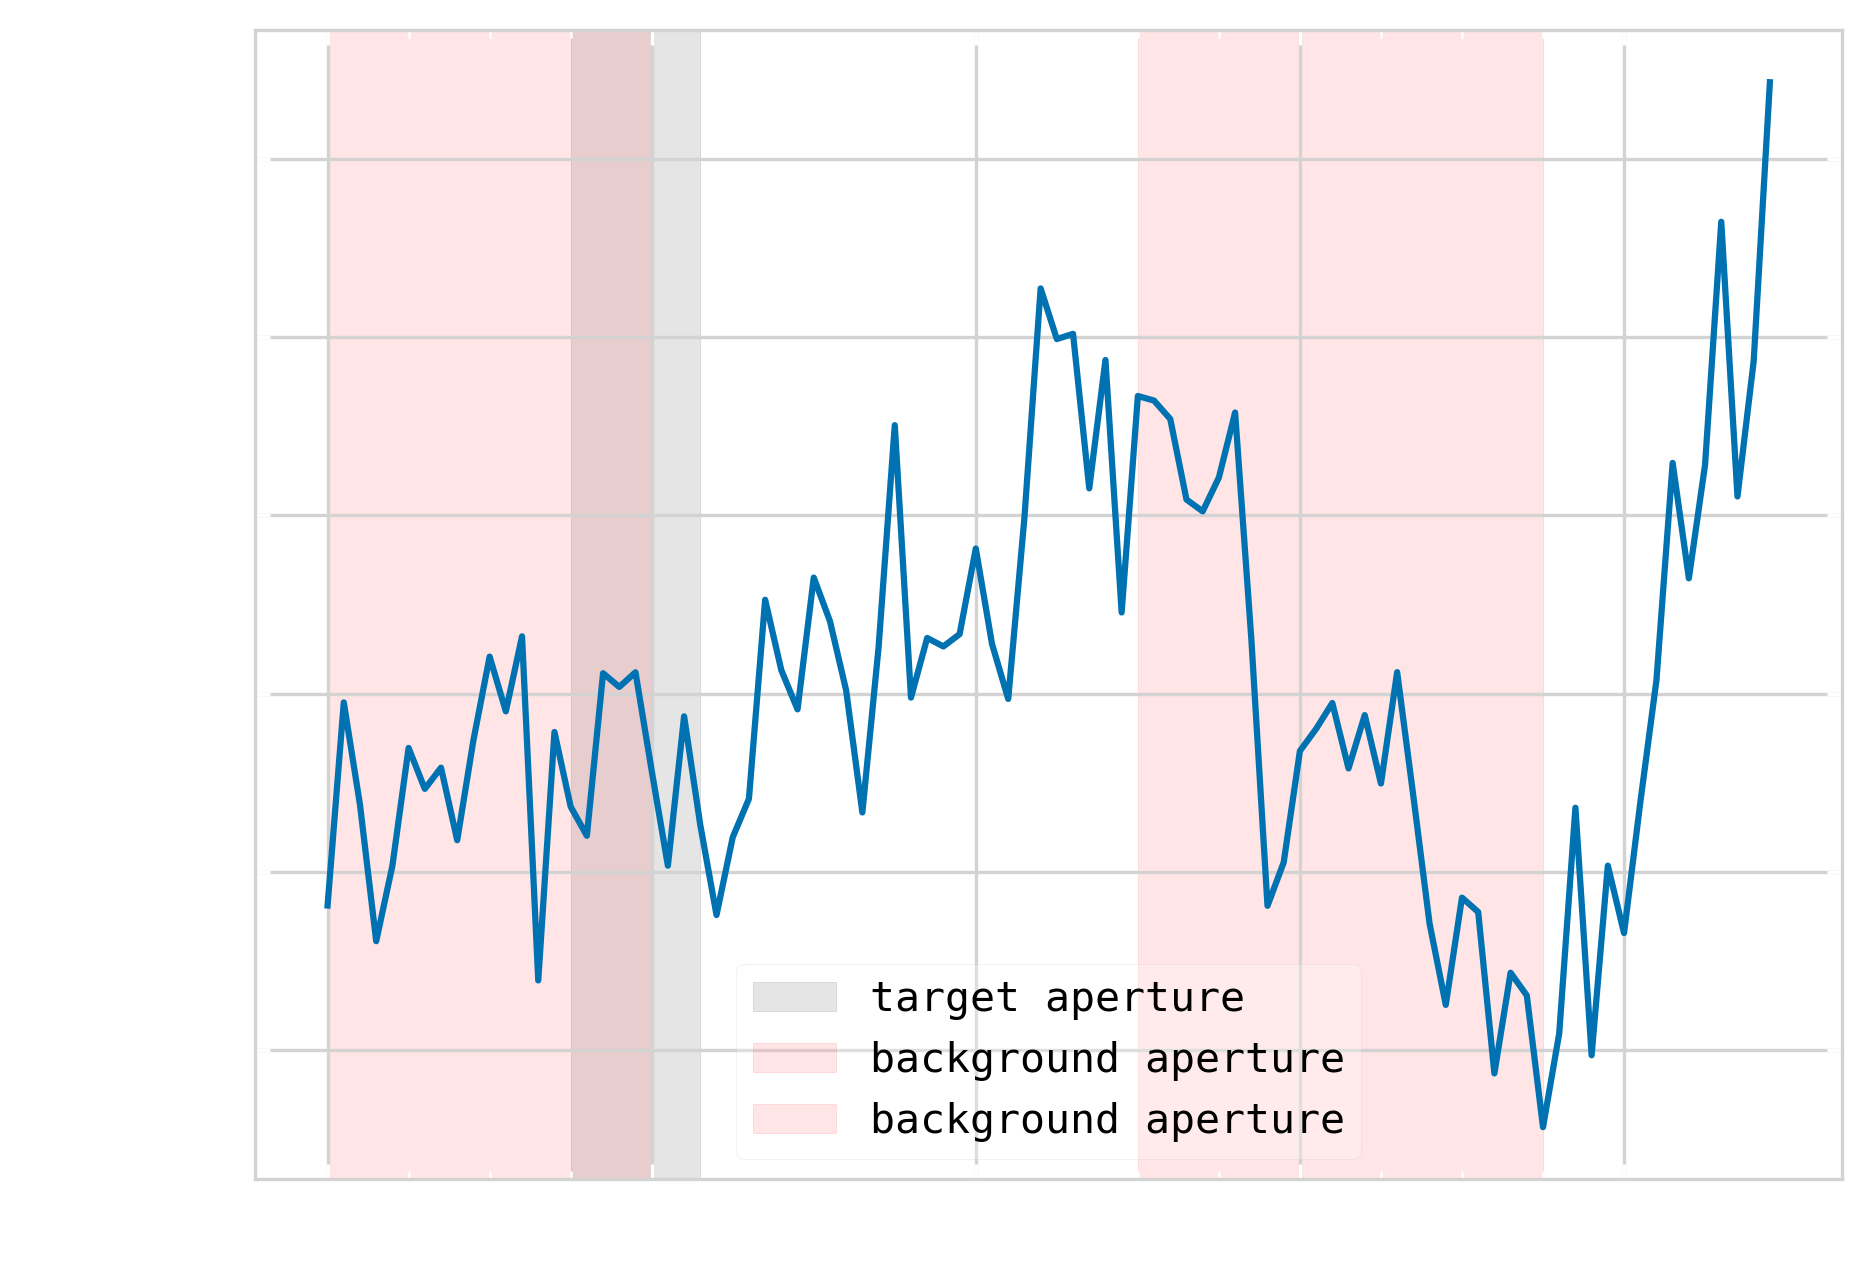

In [252]:
# plot the average of each row vs. row number
plt.plot(image.mean(axis=1))

# define the target aperture range
row1, row2 = ypix-4, ypix+4
row1_1, row2_1 = ypix1-4, ypix1+4
row1_2, row2_2 = ypix2-4, ypix2+4
plt.axvspan(row1, row2, color='k', alpha=0.1, label='target aperture')
#plt.axvspan(row1_1, row2_1, color='c', alpha=0.1, label='lower negative')
#plt.axvspan(row1_2, row2_2, color='c', alpha=0.1, label='upper negative')
spec = np.sum(image[row1:row2, :], axis=0)

# define the background aperture
# (it is best to have two bands--one on each side of the target aperture)
bg_apertures = []
bg_apertures.append((0, 20))
bg_apertures.append((50, 75))
for bgrow1, bgrow2 in bg_apertures:
    plt.axvspan(bgrow1, bgrow2, color='r', alpha=0.1, label='background aperture')

plt.legend();

candidate line at  9941.0 AA;  177.0 pix


Text(132.0, 0.065, 'z = 7.175')

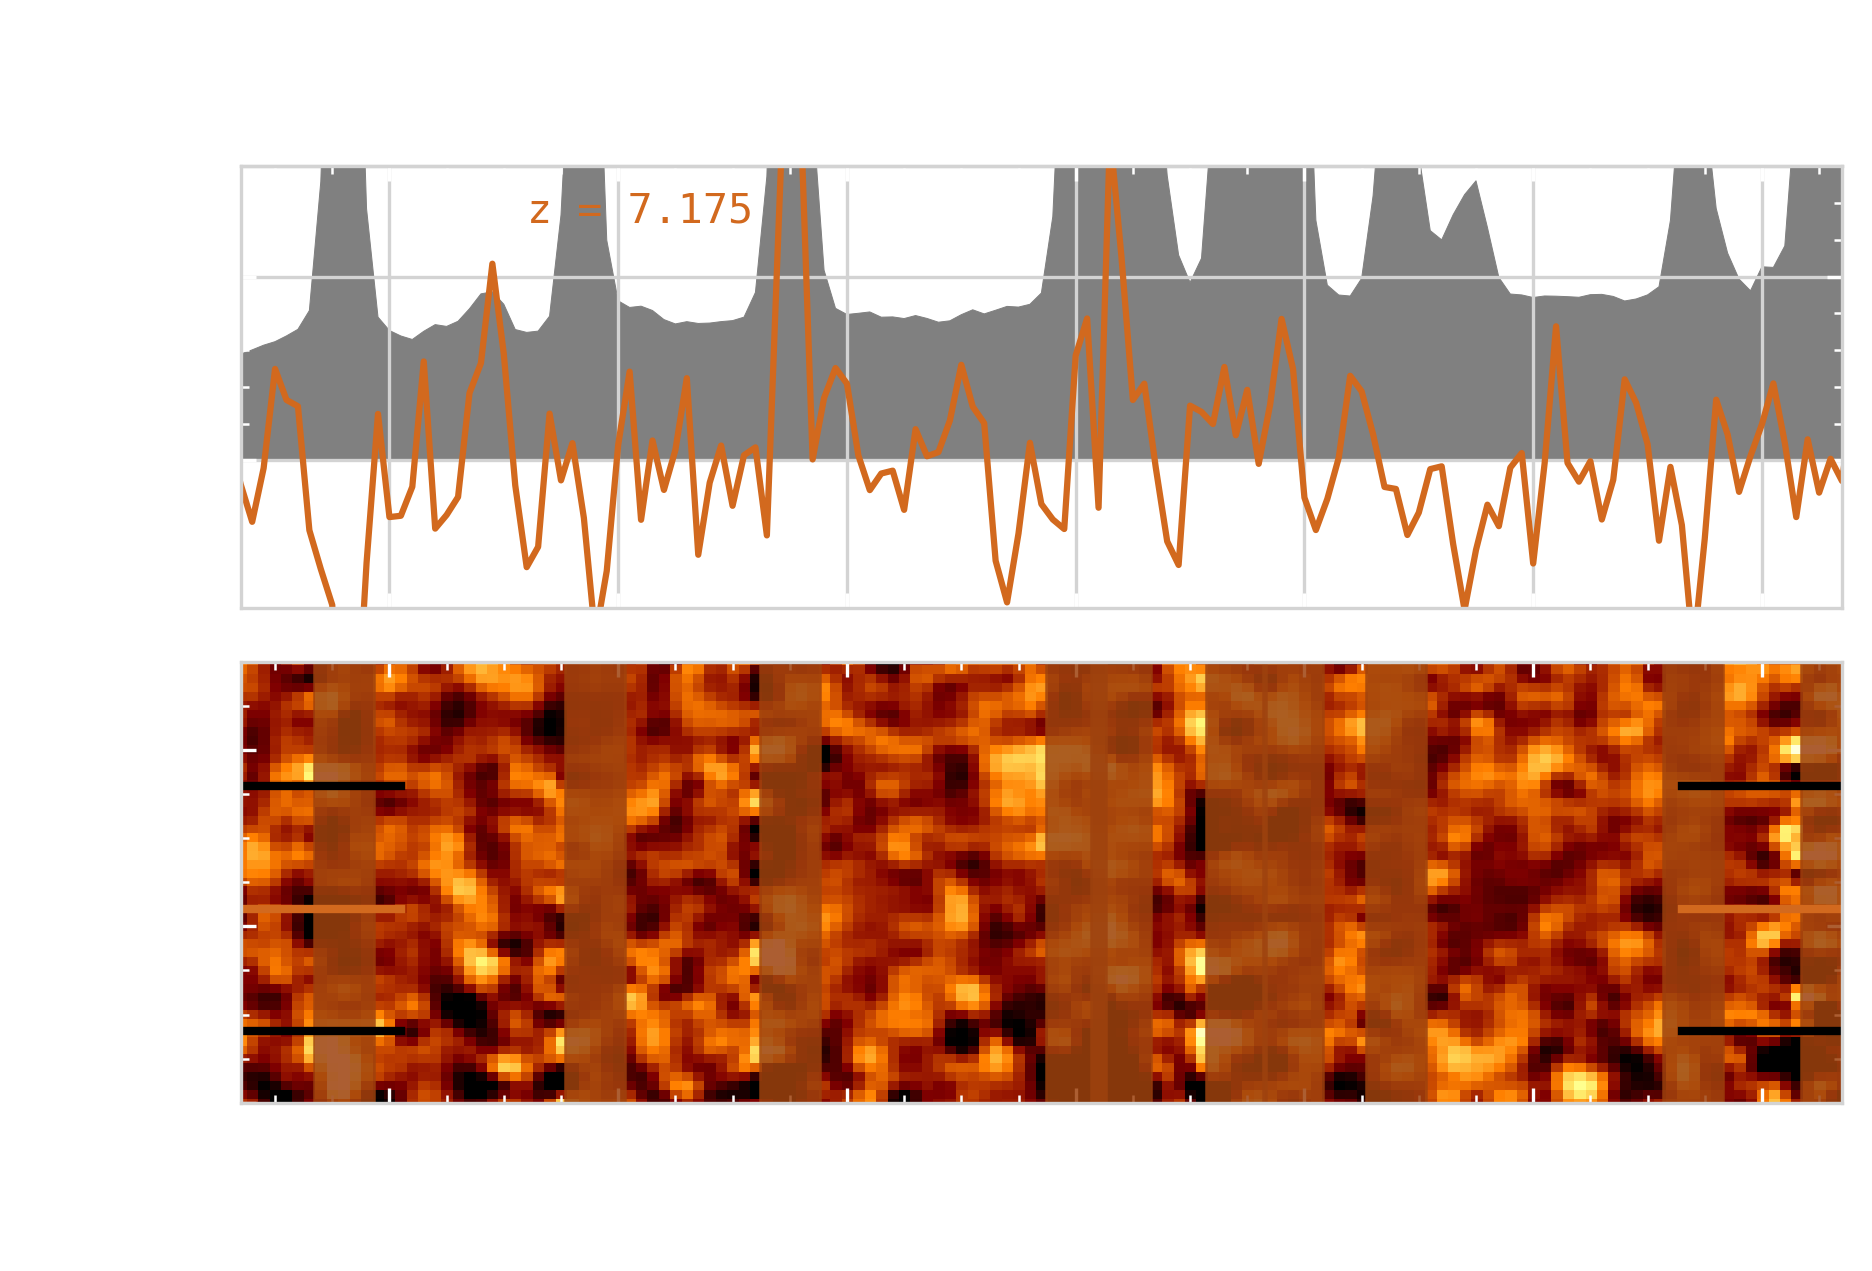

In [359]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

# ax1 = 1d spectrum in pixel space
#ax1.plot(pix_obj,spec1d_obj,c='c',label='auto mospy 1d')
ax1.plot(pix_obj,spec,c='chocolate',label=obj_name)
#ax1.plot(pix_obj,spec1,c='b',label='lower negative')
#ax1.plot(pix_obj,spec2,c='m',label='uppernegative')

ax1.fill_between(pix_sky, y1=spec1d_sky, y2=0, color='gray', label='sky')
ax1.set_ylabel(r'Flux')


### gaussian smooth
kernel = Gaussian2DKernel(x_stddev=1)
conv_im = convolve(hdu2[0].data, kernel)
# ax2 = 2d spectrum in pixel space
lower=-1; upper=2
sample = sigma_clip(hdu2[0].data) 
vmin = sample.mean() + lower * sample.std()
vmax = sample.mean() + upper * sample.std()
ax2.imshow(conv_im, origin='lower', cmap='afmhot', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Column [Pix]')
ax2.set_ylabel('Row [Pix]')
ax2.grid(False)

ipk = find_peaks(spec1d_sky, height=np.mean(spec1d_sky))[0]
for i in ipk:
    ax2.axvline(pix_sky[i],c='#9E420E',lw=15,alpha=0.85)
#plt.plot(pix_sky,spec1d_sky,'b.')
#ax2.axhline(row1,c='c',lw=1)
#ax2.axhline(row2,c='c',lw=1)
#ax2.axhline(row1_1,c='b',lw=1)
#ax2.axhline(row2_1,c='b',lw=1)
#ax2.axhline(row1_2,c='m',lw=1)
#ax2.axhline(row2_2,c='m',lw=1)
#ax2.axvline(xpix-3,lw=1)
#ax2.axvline(xpix+3,lw=1)
# secax = secondary axis for wavelength space

def forward(x):
    return np.interp(x, pix_obj, wav_obj)

def inverse(x):
    return np.interp(x, wav_obj, pix_obj)

secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r'Wavelength [$\AA$]')

# mark measured line at pixel guess based on lambda guess
pguess = pix_obj[rmp.closest(wav_obj,lguess)[0]] # pixel closest to wavelength of line to center on
print("candidate line at ",lguess,'AA; ',pguess,'pix')

ax2.axhline(obj_pos,xmin=0,xmax=0.1,lw=2,c='chocolate')
ax2.axhline(obj_pos,xmin=0.9,xmax=1,lw=2,c='chocolate')
ax2.axhline(obj_pos+nodamp,xmin=0,xmax=0.1,lw=2,c='k')
ax2.axhline(obj_pos+nodamp,xmin=0.9,xmax=1,lw=2,c='k')
ax2.axhline(obj_pos-nodamp,xmin=0,xmax=0.1,lw=2,c='k')
ax2.axhline(obj_pos-nodamp,xmin=0.9,xmax=1,lw=2,c='k')



### change limits!
#ax1.legend()
ax1.set_xlim(pguess-70,pguess+70)
ax1.set_ylim(-0.04,0.08)
ax2.set_xlim(pguess-70,pguess+70)
ax2.set_ylim(0,50) 
ax1.annotate('z = '+str(zguess),xy=(pguess-45,0.065),fontsize=10,c='chocolate')

#fig.savefig('plots/wmmc01/'+obj_name+'_manual_boxcar_1D_2D_lines.png',dpi=500)

In [74]:
possum = np.sum(spec[xpix-3:xpix+3])
negsum = np.abs(np.sum(spec1[xpix-3:xpix+3])+np.sum(spec2[xpix-3:xpix+3]))
negsum/possum

1.6457201325093376

In [4]:
# the basics

import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.table import Table
import extract_1d_spec as ex ### this is the code to do the extraction, go look at the script!
import read_mospy_files as rmp ## script I made to read in mospy files
plt.style.use('../../cooper-paper.mplstyle')

In [99]:
### CHANGE THESE TO MATCH YOUR PATH AND OBJECT YOU WANT

obj_name = 'star_243' ### change me!
dir = '../wmmc03/mospy_products/COMBINED/wmmc03b_COMBINED_' ### change me! this path WILL be different on your computer

In [100]:
aper=5;width=4;obj=obj_name;path=dir;ycen=64
# making sure the aperture is an odd number
assert aper%2 == 1, "Aperture size needs to be an odd number of pixels. "\
    f"Currently, the aperture size is: \n \t\t  aper = {aper} pixels (default is 7 pixels)."

# reading in data
print(f'\nReading in data for {obj}')
header = fits.getheader(path + obj + '_eps.fits')
signal = fits.getdata(path + obj + '_eps.fits')
error = fits.getdata(path + obj + '_sig.fits')
print(f'Dimensions: \t signal spectrum {signal.shape}\n' +
        f'\t\t error spectrum {error.shape}')

wavelength_start = header['CRVAL1'] # starting wavelength at first pixel
wavelength_logdisp = header['CD1_1'] # delta wavelength per pixel
num_wavelength = header['NAXIS1'] # length of data array
wave = wavelength_start + np.arange(0, wavelength_logdisp*num_wavelength, wavelength_logdisp) # wavelength

# defining optimized extraction gaussian
pixscale = header['PSCALE'] # arcsec/pix
fwhm = 0.8 / pixscale # arcsec / [arcsec/pixel]
gauss = ex.gaussian(np.arange(aper),mean=3.,A=1.,sig=fwhm/2.35,offset=0.)
gauss /= sum(gauss) # to make it sum to 1 to use as weights
gauss_2D = np.zeros((len(gauss),len(wave))) # making 2D array of weights
for i in range(aper):
    gauss_2D[i] = gauss[i]



Reading in data for star_243
Dimensions: 	 signal spectrum (51, 1373)
		 error spectrum (51, 1373)


In [53]:
len(gauss)

5

/var/folders/pg/yy4jmlqx6jdd_b30vyvvg93h0000gq/T/ipykernel_9683/2816176250.py:2: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(signal[ycen-half:ycen+half+1].copy())


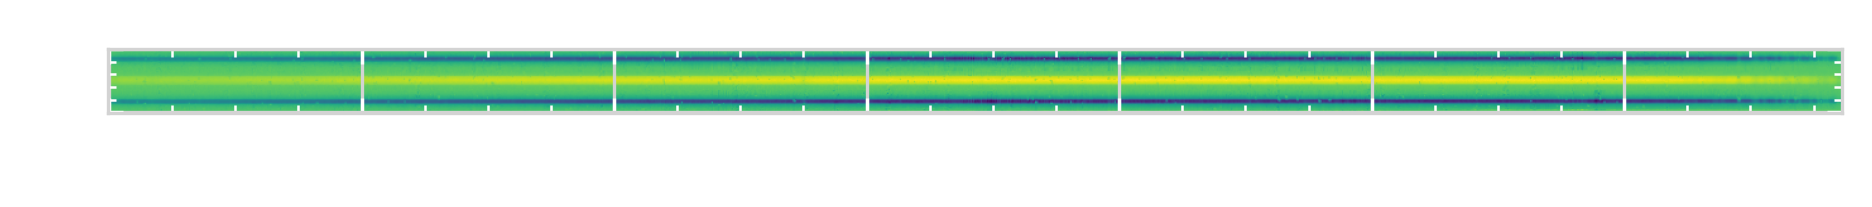

In [101]:
half = int(aper/2) # to make the cut out of the 2D image
plt.imshow(signal[ycen-half:ycen+half+1].copy())
plt.imshow(signal)

In [55]:

	# optimally-extracting 1D spectra
	half = int(aper/2) # to make the cut out of the 2D image
	spec = np.nansum(signal[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
	err = np.nansum(error[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
    
	# boxcar extract 1D spec
	row1, row2 = ycen-width, ycen+width # define the target aperture range
	specbox = np.sum(signal[row1:row2, :], axis=0)
	errbox = np.sum(error[row1:row2, :], axis=0)

In [51]:
signal[ycen-half:ycen+half+1].shape

(7, 1373)

In [62]:
# manually extract 1D spec

ypix = 64 ### change me to the ypixel you are extracting the spectrum from
wav, opt, opterr, box, boxerr = ex.extract1d(obj=obj_name,path=dir,ycen=ypix,aper=7,width=4) 


Reading in data for CAND_M44480
Dimensions: 	 signal spectrum (94, 1373)
		 error spectrum (94, 1373)


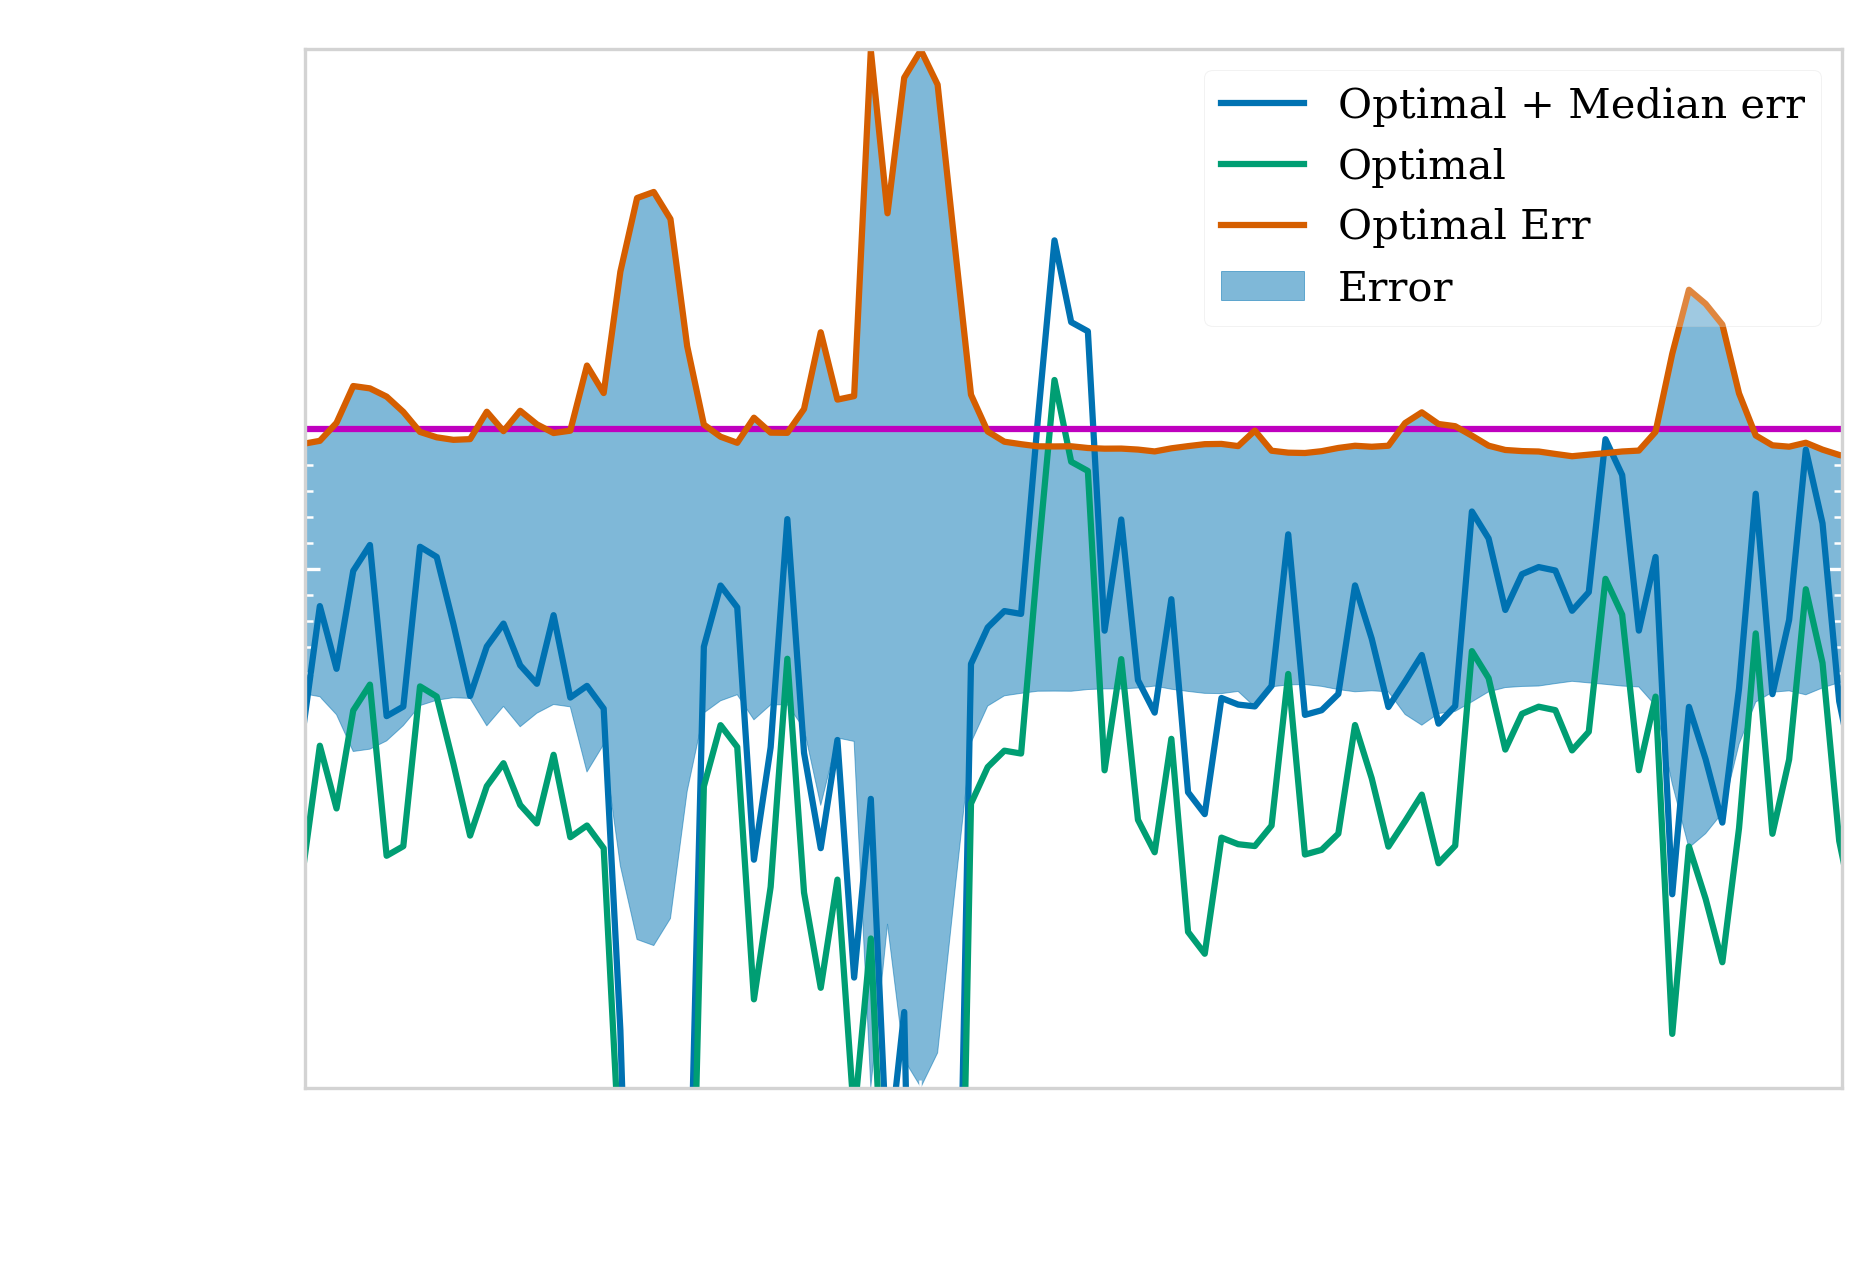

In [72]:
# plot optimal

plt.plot(wav,opt+np.median(opterr),label='Optimal + Median err')
plt.plot(wav,opt,label='Optimal')
plt.axhline(np.median(opterr),c='m')
plt.plot(wav,opterr,label='Optimal Err')
plt.fill_between(wav,opterr,-1*opterr,alpha=0.5,color='C0',label='Error')
plt.xlim(11050,11150) ### change me!
plt.ylim(-0.02,0.02) ### change me!
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux')
plt.grid(False)
plt.legend()

In [102]:
# get the a pixel coordinate near the image center (for later use)
ny, nx = signal.shape
cy, cx = ny//2, nx//2

# create 1d arays of the possible x and y values (for later use)
xs = np.arange(nx)
ys = np.arange(ny)

# pixel coordinates for each pixel (for later use)
yvals, xvals = np.indices(signal.shape)

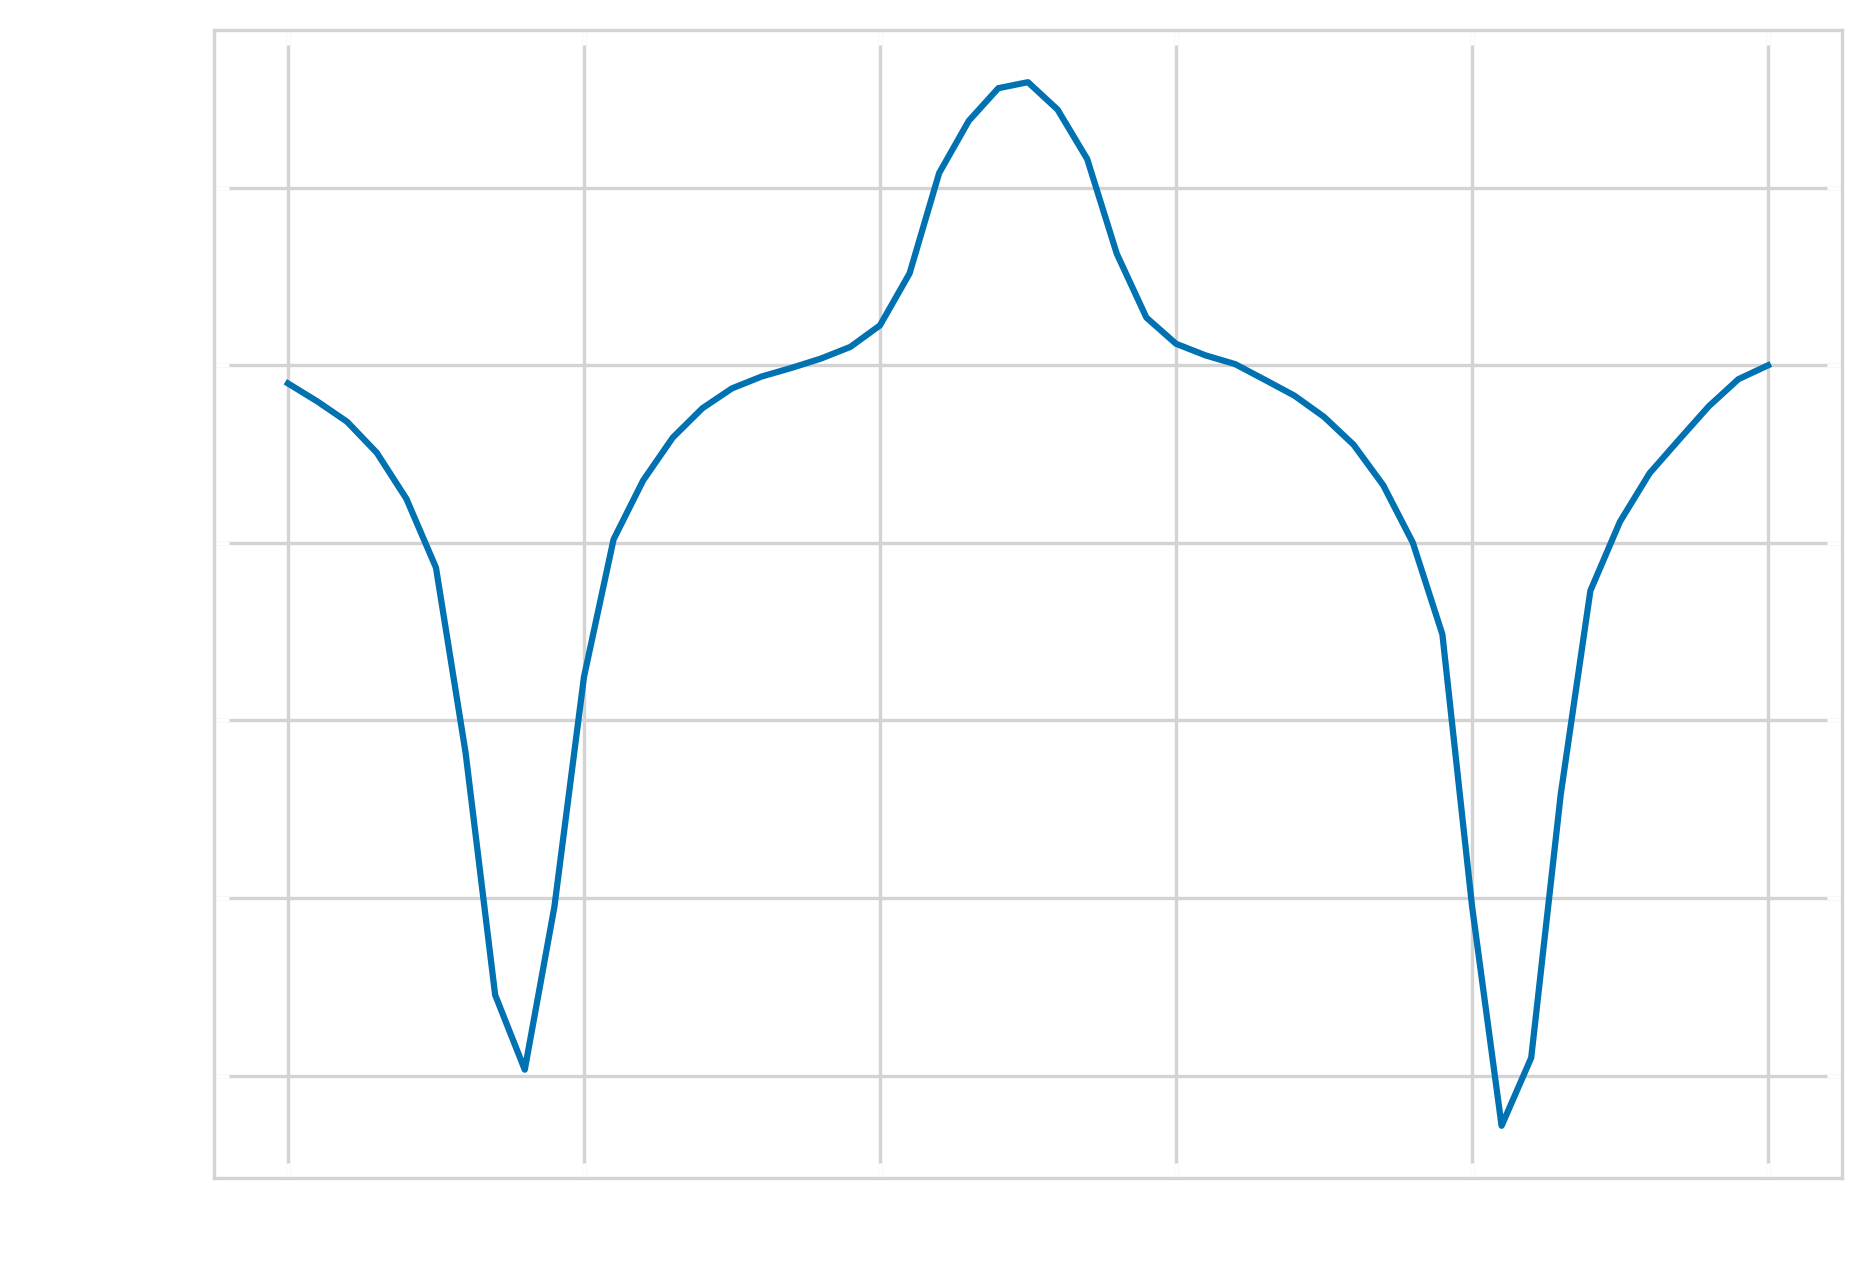

In [104]:
plt.plot(signal.sum(axis=1))

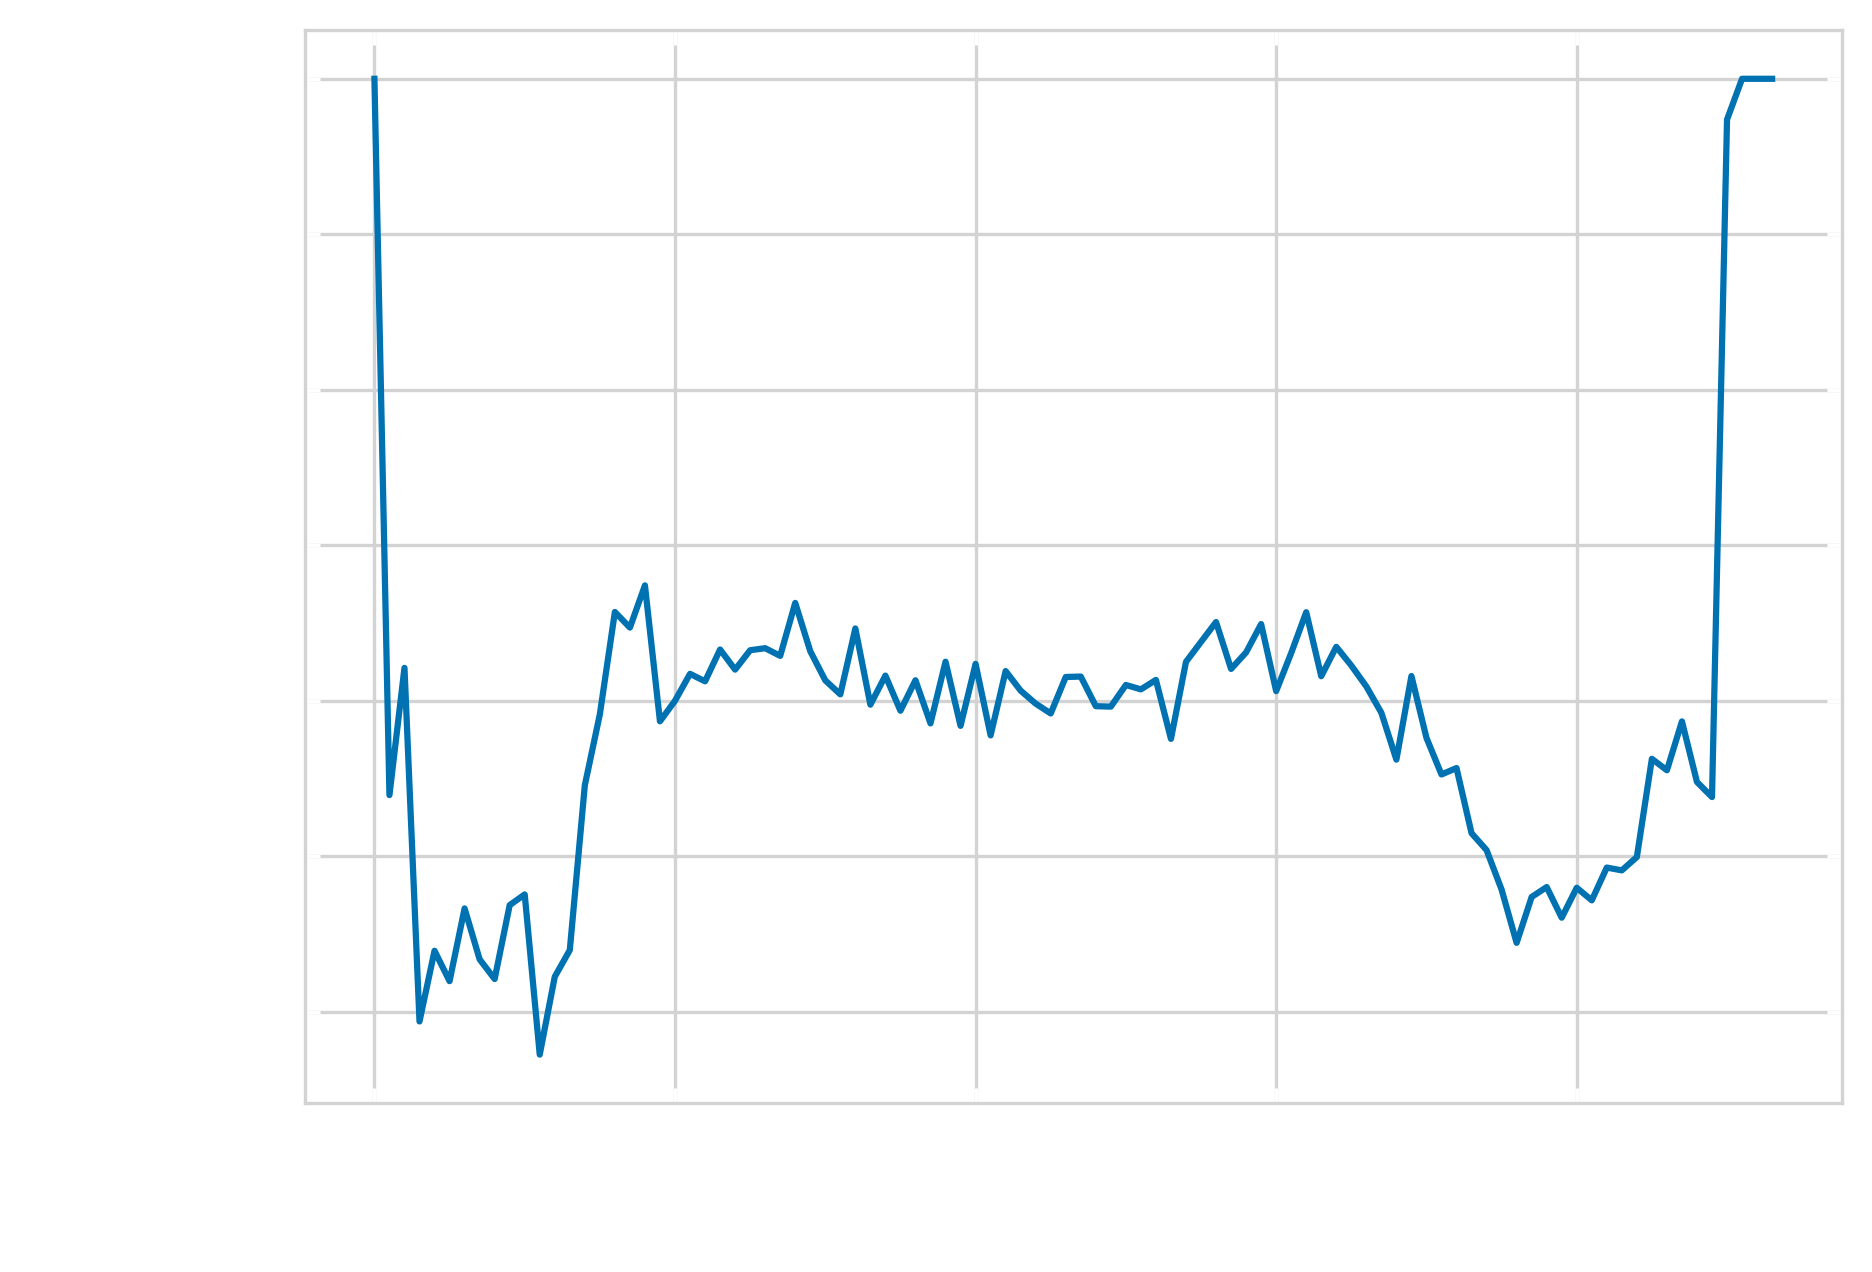

In [84]:
# calculate the weighted average (for each column)
spec_opt = signal[ycen-half:ycen+half+1].sum(axis=0) / signal.sum(axis=0)

# calculate the bias factor needed to scale the average to a sum
bias_factor = np.median(spec_basic / spec_opt)
spec_opt *= bias_factor

# same for the sky background
skybg_opt = (sky * profile_image)[ymin:ymax, :].sum(axis=0) / profile_image.sum(axis=0)
bias_factor_sky = np.median(skybg_basic / skybg_opt)
skybg_opt *= bias_factor_sky

# plot the extracted spectrum
plt.plot(xs, spec_basic, label='basic extraction')
plt.plot(xs, spec_opt, label='optimal extraction')
plt.xlabel('Column Number')
plt.ylabel('Counts');

In [83]:
signal

array([[ 0.00468454,  0.01037944,  0.00189386, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00440895, -0.00993039,  0.00171975, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00383169, -0.01359725, -0.01444962, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00670751, -0.01219111, -0.00900587, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00094348,  0.0068794 , -0.0032192 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)